In [13]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [14]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection to PostgreSQL successful\n")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")


query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)


df_all['ind_code'] = df_all['ind_code'].str.strip()


print("Available indicators:")
print(sorted(df_all['ind_code'].unique()))
print()


df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

print(f"Data loaded: {df.shape}")
print(f"Columns: {sorted(df.columns.tolist())}\n")


df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month'])
df = df.asfreq('MS')

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df


Connection to PostgreSQL successful



C:\Users\bankw\AppData\Local\Temp\ipykernel_44420\3811304260.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Available indicators:
['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']

Data loaded: (222, 11)
Columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP', 'date_month']

Data preparation completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2007-01-01 to 2025-06-01
Freq: MS
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXR     222 non-null    float64
 1   OILP    222 non-null    float64
 2   PMI     222 non-null    float64
 3   TDC     222 non-null    float64
 4   TRI     222 non-null    float64
 5   TRP     222 non-null    float64
 6   TRPD    222 non-null    float64
 7   TRS     222 non-null    float64
 8   TRX     222 non-null    float64
 9   WRP     222 non-null    float64
dtypes: float64(10)
memory usage: 19.1 KB

Train data shape: (204, 10)
Test data shape: (18, 10)


C:\Users\bankw\AppData\Local\Temp\ipykernel_44420\3811304260.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


ind_code,EXR,OILP,PMI,TDC,TRI,TRP,TRPD,TRS,TRX,WRP
date_month,,,,,,,,,,
2007-01-01,36.1800,2103.5052,54.8,30652000.0,55000.0,65.12,328940000.0,2.806710e+08,267567000.0,75.1683
2007-02-01,35.7500,2208.9925,55.1,26790000.0,44000.0,72.91,267868000.0,2.490050e+08,237979000.0,81.4653
2007-03-01,35.0600,2309.4022,53.1,31717000.0,119000.0,69.62,246813000.0,2.173390e+08,230410000.0,78.6261
2007-04-01,34.8700,2291.3077,56.1,27788000.0,184000.0,72.84,165458000.0,1.785750e+08,180185000.0,80.9071
2007-05-01,34.6200,2216.0262,58.6,32905000.0,91000.0,71.47,172153000.0,2.092150e+08,178103000.0,82.0040
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,33.9385,2367.5498,50.2,109368000.0,63000.0,67.91,578922000.0,1.050152e+09,369222000.0,82.4825
2025-03-01,33.9768,2428.6617,50.5,95398000.0,111000.0,66.56,413728000.0,9.991970e+08,369396000.0,81.3680
2025-04-01,33.9148,1974.1805,49.0,69306000.0,73000.0,59.69,267722000.0,8.799700e+08,317716000.0,73.9204


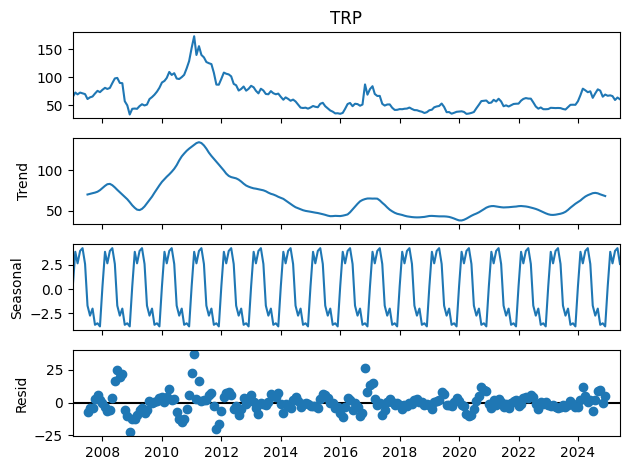

In [15]:
# Block 3 – Seasonal decomposition (เหมือนเดิม)

result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()


Available columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected external factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Mean TRP (train): 64.5769
X_train: (204, 9)  X_test: (18, 9)


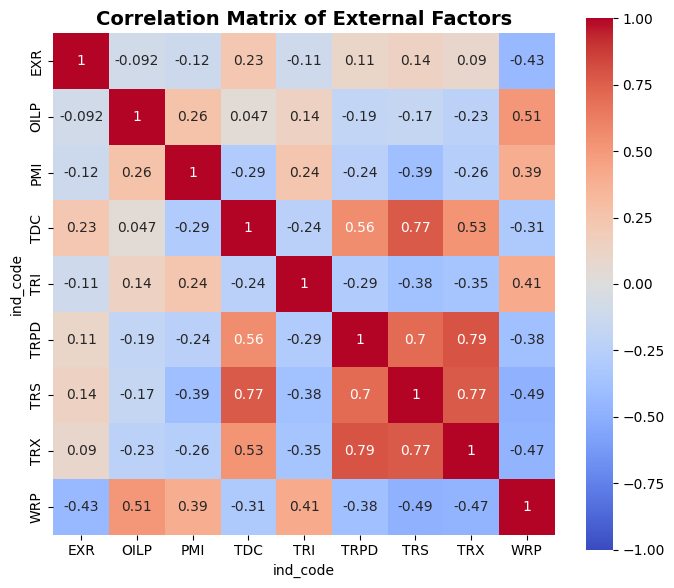

In [16]:
external_factors = ['EXR', 'OILP', 'PMI','TDC', 'TRI', 'TRPD','TRS', 'TRX', 'WRP']

print("Available columns:", df.columns.tolist())
print("Selected external factors:", [c for c in external_factors if c in df.columns])
print()

#เตรียม X, y
train_exog = train_data[external_factors].copy()
test_exog  = test_data[external_factors].copy()

X_train_raw = train_exog.copy()
X_test_raw  = test_exog.copy()
y_train = train_data['TRP']
y_test  = test_data['TRP']

mean_trp = y_train.mean()
print(f"Mean TRP (train): {mean_trp:.4f}")
print("X_train:", X_train_raw.shape, " X_test:", X_test_raw.shape)

# Scaling (ใช้กับทุกโมเดล Ridge)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test  = scaler.transform(X_test_raw)

# Correlation matrix ของ external factors
corr = train_exog.corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    square=True
)
plt.title("Correlation Matrix of External Factors", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [17]:
before_model = Ridge(alpha=1.0, random_state=42)

before_model.fit(X_train, y_train)
pred_before = before_model.predict(X_test)

rmse_before = np.sqrt(mean_squared_error(y_test, pred_before))
mape_before = mean_absolute_percentage_error(y_test, pred_before) * 100

print("=== BEFORE MODEL (Baseline Ridge) ===")
print(f"RMSE : {rmse_before:.4f}")
print(f"MAPE : {mape_before:.2f}%")


=== BEFORE MODEL (Baseline Ridge) ===
RMSE : 2.4089
MAPE : 2.98%


In [18]:
import optuna

def objective_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1e3, log=True)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    model = Ridge(alpha=alpha, fit_intercept=fit_intercept, random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    return rmse

study_ridge = optuna.create_study(direction="minimize")
study_ridge.optimize(objective_ridge, n_trials=60)

best_ridge_params = study_ridge.best_params
print("\n=== OPTUNA BEST PARAMS (Ridge) ===")
print(best_ridge_params)


[I 2025-11-25 03:12:23,905] A new study created in memory with name: no-name-168c66be-eb78-4997-b79e-da77ecb45f26
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-25 03:12:23,910] Trial 0 finished with value: 2.3909732290033108 and parameters: {'alpha': 0.009741002285372407, 'fit_intercept': True}. Best is trial 0 with value: 2.3909732290033108.
c:\Users\bankw\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2025-11-25 03:12:23,911] Trial 1 finished with value: 4.264452953453806 and parameters: {'alpha': 20.


=== OPTUNA BEST PARAMS (Ridge) ===
{'alpha': 0.0001006276315167472, 'fit_intercept': True}


In [19]:
after_model = Ridge(
    alpha=best_ridge_params["alpha"],
    fit_intercept=best_ridge_params["fit_intercept"],
    random_state=42
)

after_model.fit(X_train, y_train)
pred_after = after_model.predict(X_test)

rmse_after = np.sqrt(mean_squared_error(y_test, pred_after))
mape_after = mean_absolute_percentage_error(y_test, pred_after) * 100

print("=== AFTER MODEL (Optuna Tuned Ridge) ===")
print(f"RMSE : {rmse_after:.4f}")
print(f"MAPE : {mape_after:.2f}%")


=== AFTER MODEL (Optuna Tuned Ridge) ===
RMSE : 2.3909
MAPE : 2.96%


In [20]:
def compute_score(rmse, mape, mean_trp, w_rmse=0.5, w_mape=0.5):
    """
    Unified Score 0–100 จาก RMSE และ MAPE
    """
    nrmse = rmse / mean_trp        # Normalize ด้วย mean ของ TRP
    mape_norm = mape / 100.0
    score = 100 * (1 - (w_rmse*nrmse + w_mape*mape_norm))
    return max(0, min(100, score))

score_before = compute_score(rmse_before, mape_before, mean_trp)
score_after  = compute_score(rmse_after,  mape_after,  mean_trp)

summary_df = pd.DataFrame({
    "Model": ["Before (Baseline Ridge)", "After (Optuna Ridge)"],
    "RMSE": [rmse_before, rmse_after],
    "MAPE (%)": [mape_before, mape_after],
    "Score (0-100)": [score_before, score_after]
})

print("=== COMPARISON: BEFORE vs AFTER (Ridge) ===")
print(summary_df.to_string(index=False))


=== COMPARISON: BEFORE vs AFTER (Ridge) ===
                  Model     RMSE  MAPE (%)  Score (0-100)
Before (Baseline Ridge) 2.408899  2.982640      96.643539
   After (Optuna Ridge) 2.390895  2.955729      96.670934


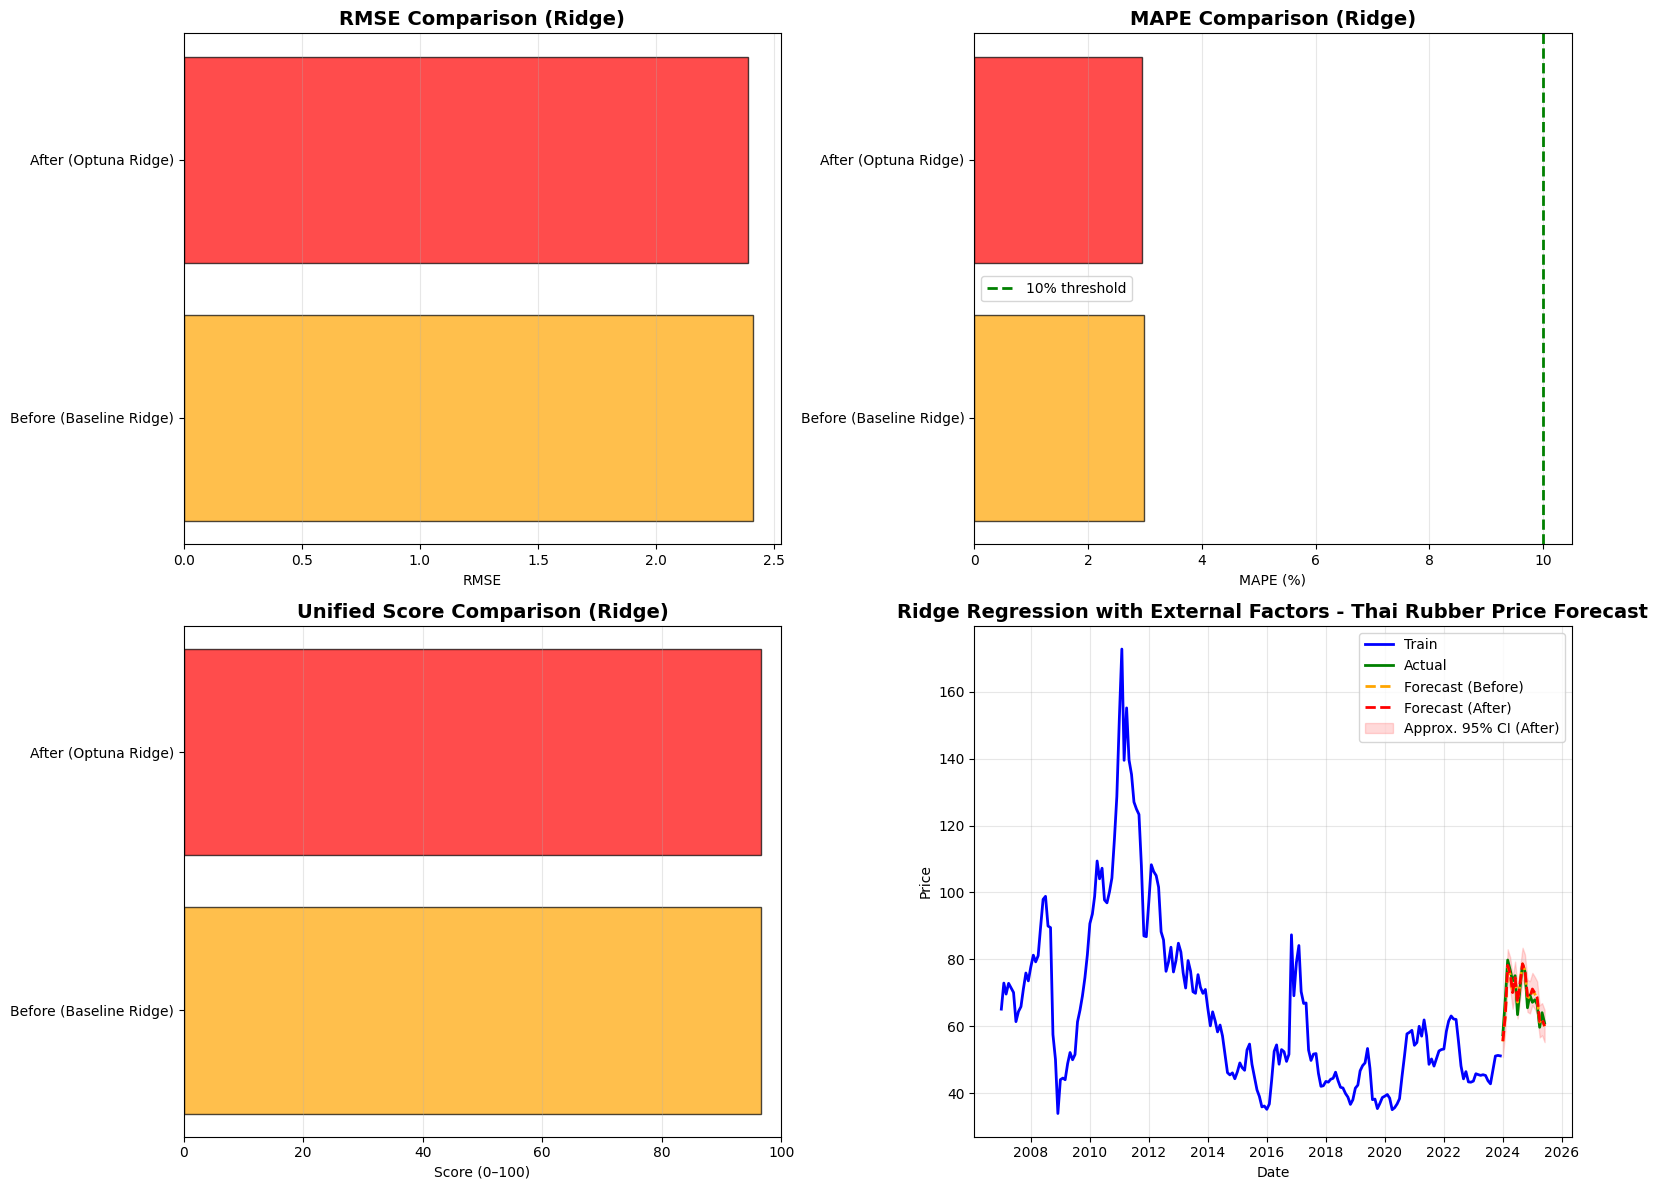

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = summary_df["Model"].tolist()
rmse_vals = summary_df["RMSE"].tolist()
mape_vals = summary_df["MAPE (%)"].tolist()
score_vals = summary_df["Score (0-100)"].tolist()

#RMSE Comparison
ax = axes[0, 0]
ax.barh(models, rmse_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.set_xlabel("RMSE")
ax.set_title("RMSE Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")

#MAPE Comparison
ax = axes[0, 1]
ax.barh(models, mape_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.axvline(x=10, color="green", linestyle="--", linewidth=2, label="10% threshold")
ax.set_xlabel("MAPE (%)")
ax.set_title("MAPE Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="x")

#Score Comparison
ax = axes[1, 0]
ax.barh(models, score_vals, color=["orange", "red"], edgecolor="black", alpha=0.7)
ax.set_xlabel("Score (0–100)")
ax.set_xlim(0, 100)
ax.set_title("Unified Score Comparison (Ridge)", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")

#Forecast Plot (After + Before)
pred_before_series = pd.Series(pred_before, index=test_data.index)
pred_after_series  = pd.Series(pred_after,  index=test_data.index)

ax = axes[1, 1]
ax.plot(train_data.index, train_data['TRP'], label="Train", color="blue", linewidth=2)
ax.plot(test_data.index,  test_data['TRP'],  label="Actual", color="green", linewidth=2)
ax.plot(pred_before_series.index, pred_before_series.values,
        label="Forecast (Before)", color="orange", linestyle="--", linewidth=2)
ax.plot(pred_after_series.index, pred_after_series.values,
        label="Forecast (After)", color="red", linestyle="--", linewidth=2)

# CI แบบคร่าว ๆ จาก residual ของ After
residuals = test_data['TRP'] - pred_after_series
sigma = residuals.std()
upper = pred_after_series + 1.96 * sigma
lower = pred_after_series - 1.96 * sigma
ax.fill_between(pred_after_series.index, lower, upper,
                color="red", alpha=0.15, label="Approx. 95% CI (After)")

ax.set_title("Ridge Regression with External Factors - Thai Rubber Price Forecast",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


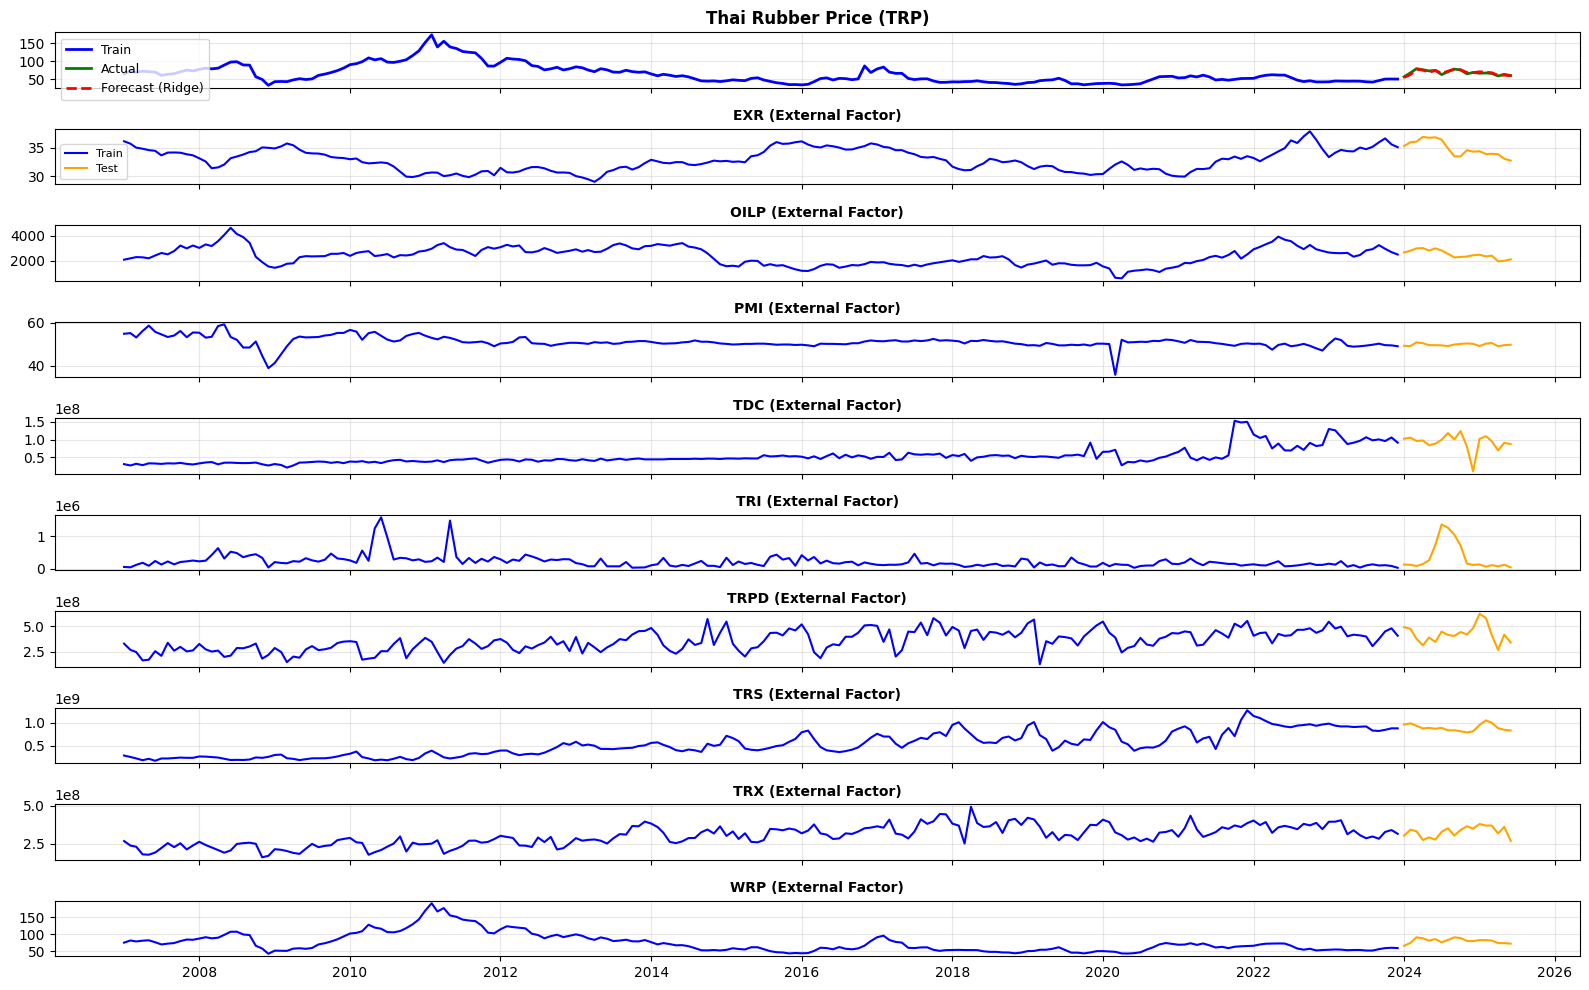

In [22]:
num_factors = len(external_factors)
fig, axes = plt.subplots(num_factors + 1, 1,
                         figsize=(16, 10),
                         sharex=True)

ax0 = axes[0]
ax0.plot(train_data.index, train_data['TRP'],
         label='Train', color='blue', linewidth=2)
ax0.plot(test_data.index, test_data['TRP'],
         label='Actual', color='green', linewidth=2)
ax0.plot(pred_after_series.index, pred_after_series.values,
         label='Forecast (Ridge)', color='red', linestyle='--', linewidth=2)
ax0.set_title('Thai Rubber Price (TRP)', fontweight='bold')
ax0.legend(fontsize=9)
ax0.grid(True, alpha=0.3)


for i, factor in enumerate(external_factors):
    ax = axes[i+1]
    ax.plot(train_data.index, train_data[factor],
            label='Train', color='blue', linewidth=1.5)
    ax.plot(test_data.index, test_data[factor],
            label='Test', color='orange', linewidth=1.5)
    ax.set_title(f'{factor} (External Factor)', fontweight='bold', fontsize=10)
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


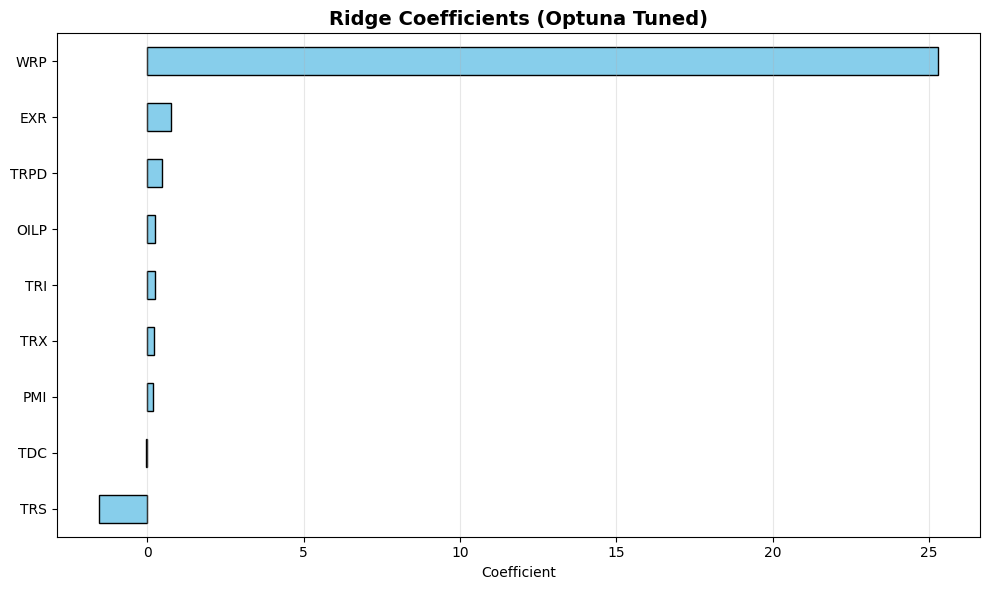

In [23]:
coef_series = pd.Series(after_model.coef_, index=external_factors).sort_values()

plt.figure(figsize=(10, 6))
coef_series.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Ridge Coefficients (Optuna Tuned)", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:
data = {
    'Model': ['Baseline (Ridge)', 'Optuna Ridge'],
    'RMSE': [rmse_before, rmse_after],
    'MAPE': [mape_before/100, mape_after/100],
    'ACCURACY': [score_before/100, score_after/100]
}

df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison (Ridge Regression)\n")
print(df_display.to_string(index=True, col_space=15))


Performance Comparison (Ridge Regression)

                            Model            RMSE        MAPE (%)    ACCURACY (%)
0                Baseline (Ridge)        2.408899           2.98%          96.64%
1                    Optuna Ridge        2.390895           2.96%          96.67%
